## Подключаю библиотеки

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, LearningCurveDisplay

## Объяснение колонок

Пол (Gender): M(Мужской), F(Женский)

Возраст (Age): Возраст пациента

Курящий (Smoking): YES=2 , NO=1.

Yellow fingers (Случай паронихии, инфицирования складок тканей вокруг ногтей. Обычно прилегающие ткани болезненны, краснеют и опухли. Может быть гной, который обычно желтого цвета, отсюда и название.): YES=2 , NO=1.

Тревожность (Anxiety): YES=2 , NO=1.

Эмоциональное давление (Peer_pressure): YES=2 , NO=1.

Хронические заболевания (Chronic Disease): YES=2 , NO=1.

Усталость (Fatigue): YES=2 , NO=1.

Аллергия (Allergy): YES=2 , NO=1.

Сопение (Wheezing): YES=2 , NO=1.

Употребление алкоголя (Alcohol): YES=2 , NO=1.

Кашель (Coughing): YES=2 , NO=1.

Одышка (Shortness of Breath): YES=2 , NO=1.

Трудности с глотанием (Swallowing Difficulty): YES=2 , NO=1.

Боли в груди (Chest pain): YES=2 , NO=1.

Рак лёгких (Lung Cancer): YES , NO.

## Загрузка и обработка

Загружаю данные, на которых будет проведено обучение

In [56]:
df_canser = pd.read_csv("survey lung cancer.csv")
df_canser.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


Проверяю загрузку

In [57]:
df_canser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

Данные успешно загружены, нули отсутствуют

In [58]:
print(f"Дубликаты: {df_canser.duplicated().sum()}")

Дубликаты: 33


In [59]:
df_canser.drop_duplicates(inplace=True)

Дубликаты удалены

In [60]:
df_canser.reset_index(inplace=True, drop=True)

# Кодирование

In [61]:
df_canser1 = df_canser.copy()

Кодирую пол и рака

In [62]:
gender_le = LabelEncoder()
cancer_le = LabelEncoder()

gender_le.fit(df_canser1["GENDER"])
cancer_le.fit(df_canser1["LUNG_CANCER"])

LabelEncoder()

In [63]:
print(gender_le.classes_)
print(cancer_le.classes_)

['F' 'M']
['NO' 'YES']


Кодирую данные

In [64]:
df_canser1["GENDER"] = gender_le.transform(df_canser1["GENDER"])
df_canser1["LUNG_CANCER"] = cancer_le.transform(df_canser1["LUNG_CANCER"])
df_canser1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   GENDER                 276 non-null    int64
 1   AGE                    276 non-null    int64
 2   SMOKING                276 non-null    int64
 3   YELLOW_FINGERS         276 non-null    int64
 4   ANXIETY                276 non-null    int64
 5   PEER_PRESSURE          276 non-null    int64
 6   CHRONIC DISEASE        276 non-null    int64
 7   FATIGUE                276 non-null    int64
 8   ALLERGY                276 non-null    int64
 9   WHEEZING               276 non-null    int64
 10  ALCOHOL CONSUMING      276 non-null    int64
 11  COUGHING               276 non-null    int64
 12  SHORTNESS OF BREATH    276 non-null    int64
 13  SWALLOWING DIFFICULTY  276 non-null    int64
 14  CHEST PAIN             276 non-null    int64
 15  LUNG_CANCER            276 non-null    i

Данные успешно закодированы

Смотрю, в каких столбцах есть выбросы

In [65]:
outlier_cols = []

for column in df_canser1.columns:
    Q1 = df_canser1[column].quantile(0.25)
    Q3 = df_canser1[column].quantile(0.75)
    IQR = Q3 - Q1

    outliers = (df_canser1[column] < Q1 - 1.5 * IQR) | (df_canser1[column] > Q3 + 1.5 * IQR)

    if any(outliers):
        outlier_cols.append(column)

print("Columns with outliers:", outlier_cols)

Columns with outliers: ['AGE', 'LUNG_CANCER']


Выбросы есть в столбце с возрастом и категориальным раком, но это даже звучит нелогично, поэтому проверка

In [66]:
df_canser1.describe()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,0.514493,62.909420,1.543478,1.576087,1.496377,1.507246,1.521739,1.663043,1.547101,1.547101,1.550725,1.576087,1.630435,1.467391,1.557971,0.862319
std,0.500698,8.379355,0.499011,0.495075,0.500895,0.500856,0.500435,0.473529,0.498681,0.498681,0.498324,0.495075,0.483564,0.499842,0.497530,0.345191
min,0.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,57.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,62.500000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000
75%,1.000000,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,1.000000,87.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


В возрасте значения удовлетворительные, поэтому мы его не трогаем

## Проверка корреляции и кластеризация

Создаю функцию для вывода таблицы корреляции по целевому признаку

In [67]:
def corrmap(df, target, *, annot=True):
    plt.figure(figsize=(15,7))
    sns.heatmap(df.corr().drop(df.columns[df.columns != target], axis=1), annot=annot)

Вывожу корреляцию значений к шансу рака

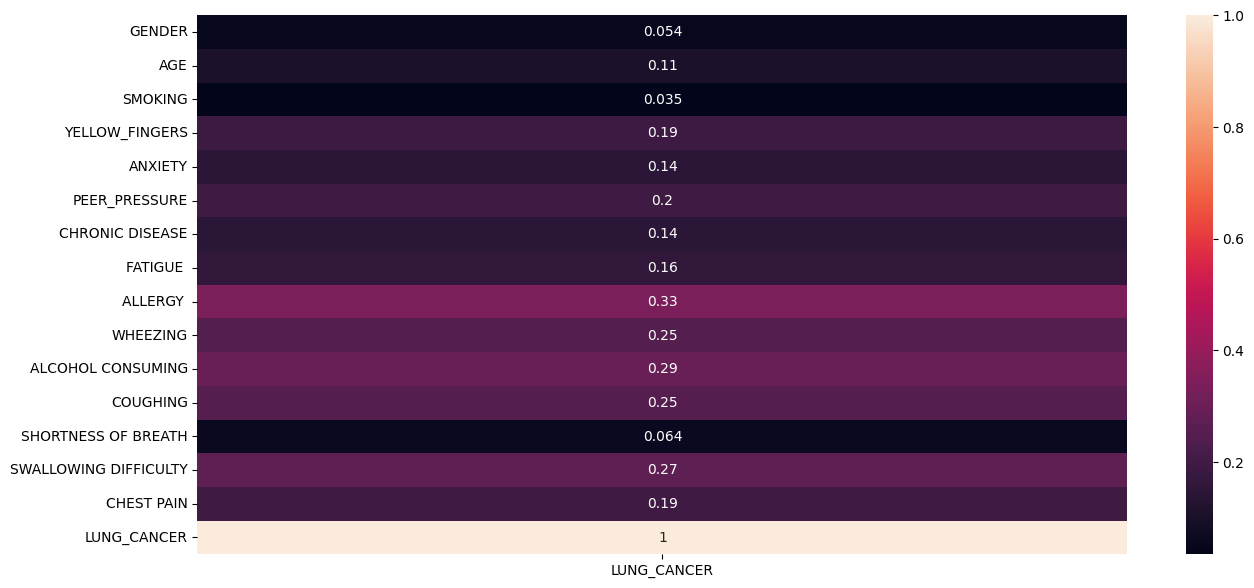

In [68]:
corrmap(df_canser1, "LUNG_CANCER")

Все значения коррелируют, но не очень хорошо

Функции для понижения размерности, использования метода локтя и кластеризации методом K-Means

In [69]:
def pca2(df):
    # Масштабирую данные
    ssc = StandardScaler()
    ddf = ssc.fit_transform(df)

    # Нормализирую данные
    norm = Normalizer()
    ddt = norm.fit_transform(ddf)
    from sklearn.decomposition import PCA


    # Уменьшаем размерность при помощи метода главных компонент
    pca = PCA(n_components=2).fit(ddt)
    pca_2d = pca.transform(ddt)
    return pca_2d

def elbow(pca_2d):
    sse = []
    # Смотрю, какая сумма квадратов расстояния для разного кол-ва класстеров
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_2d)
        sse.append(kmeans.inertia_)
    # Изображаю график метода Локтя
    plt.plot(range(1, 11), sse, marker='o')
    plt.title('Метод „Локтя“')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Сумма квадратов расстояний')
    plt.show()

list_of_color = ["red", "blue", "green", "orange", "black", "yellow"]

def KMN(df, pca_2d, n_clusters):
    # Обучаю и предсказываю кластеры по уже известному их кол-ву
    km = KMeans(n_clusters=n_clusters, random_state=0, init = 'k-means++')
    all_pred = km.fit_predict(pca_2d)
    # Визуализирую кластеры
    for k in range(n_clusters):
        plt.scatter(pca_2d[all_pred==k].T[0] , pca_2d[all_pred==k].T[1], color=list_of_color[k])
        
    plt.title(f'Кластеризация KMeans')
    plt.show()
    # Описываю характеристики по каждому столбцу каждого кластера и собираю эти характеристики в список
    for i in range(n_clusters):
        print(f"{i+1} кластер. Кол-во: {km.labels_[km.labels_==i].size}\n")
        print(f"Цвет: {list_of_color[i]}\n")
        for j in df.columns[2:]:
            print(f"Среднее {j}: {df[j][km.labels_==i].mean():.3f}")
            # print(f"Min {j}: {df[j][km.labels_==i].min():.3f}\nMax {j}: {df[j][km.labels_==i].max():.3f}\n\n")
        print()
    return km.labels_


Убираю колонку с раком, так как она не должна присутствовать в кластеризации

In [70]:
df_level_drop = df_canser1.drop(["LUNG_CANCER"], axis=1)

Понижаю размерность

In [71]:
pca_2d = pca2(df_level_drop)

Использую метод локтя для поиска оптимального кол-ва кластеров

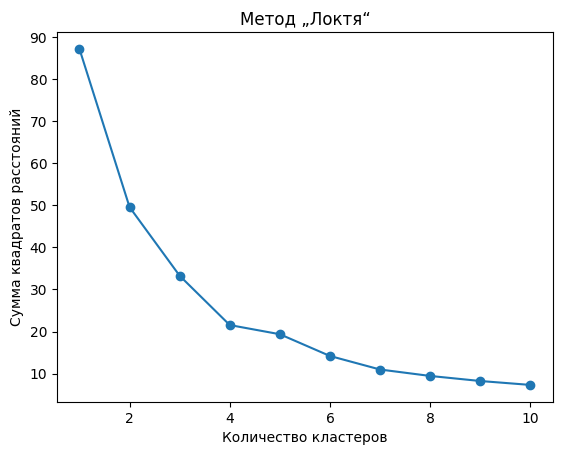

In [72]:
elbow(pca_2d)

Оптимальное кол-во кластеров - 4, так как после 4 сумма квадратов растояний не слишком сильно уменьшается

In [73]:
n_clust = 4

Кластеризация

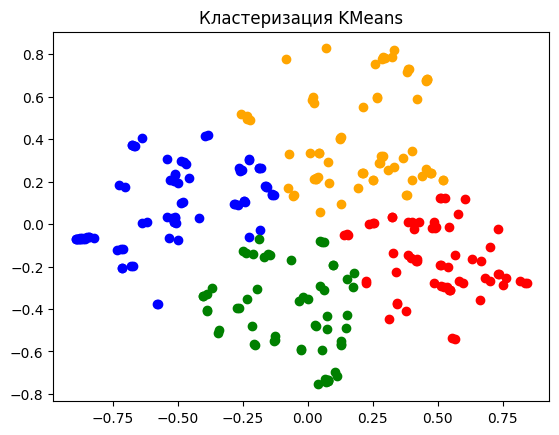

1 кластер. Кол-во: 64

Цвет: red

Среднее SMOKING: 1.734
Среднее YELLOW_FINGERS: 1.953
Среднее ANXIETY: 1.891
Среднее PEER_PRESSURE: 1.828
Среднее CHRONIC DISEASE: 1.531
Среднее FATIGUE : 1.812
Среднее ALLERGY : 1.250
Среднее WHEEZING: 1.406
Среднее ALCOHOL CONSUMING: 1.047
Среднее COUGHING: 1.469
Среднее SHORTNESS OF BREATH: 1.703
Среднее SWALLOWING DIFFICULTY: 1.656
Среднее CHEST PAIN: 1.312

2 кластер. Кол-во: 81

Цвет: blue

Среднее SMOKING: 1.580
Среднее YELLOW_FINGERS: 1.210
Среднее ANXIETY: 1.185
Среднее PEER_PRESSURE: 1.284
Среднее CHRONIC DISEASE: 1.370
Среднее FATIGUE : 1.802
Среднее ALLERGY : 1.840
Среднее WHEEZING: 1.778
Среднее ALCOHOL CONSUMING: 2.000
Среднее COUGHING: 1.864
Среднее SHORTNESS OF BREATH: 1.716
Среднее SWALLOWING DIFFICULTY: 1.272
Среднее CHEST PAIN: 1.840

3 кластер. Кол-во: 60

Цвет: green

Среднее SMOKING: 1.350
Среднее YELLOW_FINGERS: 1.400
Среднее ANXIETY: 1.083
Среднее PEER_PRESSURE: 1.350
Среднее CHRONIC DISEASE: 1.633
Среднее FATIGUE : 1.817
Среднее

In [74]:
clust = KMN(df_level_drop, pca_2d, n_clust)

Добавляю новую колонку с номером кластера

In [75]:
df_canser2 = df_canser1.copy()
df_canser2["clust"] = clust

In [76]:
df_canser2

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,clust
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1,2
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0,2
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0,3
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0,59,1,2,2,2,1,1,2,2,1,2,1,2,1,1,3
272,0,59,2,1,1,1,2,2,2,1,1,1,2,1,1,0,2
273,1,55,2,1,1,1,1,2,2,1,1,1,2,1,2,0,2
274,1,46,1,2,2,1,1,1,1,1,1,1,1,2,2,0,3


Вывожу корреляцию, но уже с кластерами

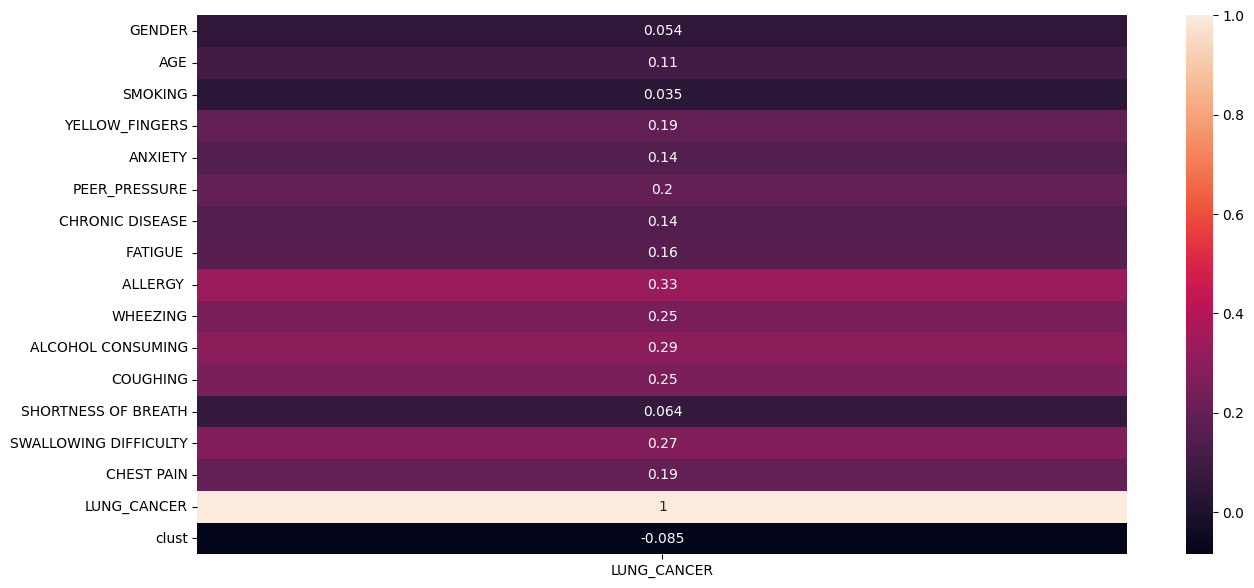

In [77]:
corrmap(df_canser2, "LUNG_CANCER")

##  Классификация

### Предобработка

Делю данные на признаки и целевые значения

In [78]:
X = df_canser2.drop(["LUNG_CANCER"], axis=1)
y = df_canser2["LUNG_CANCER"]

In [79]:
l_col = ["gender", "age", "smoking", "yellow_fingers", "anxiety", "peer_pressure", "chronic_disease", "fatigue", "allergy", "wheezing", "alcohol", "coughing", "shortness_of_breath", "swallowing_difficulty", "chest_pain"]

In [80]:
d_col = {i:j for i,j in zip(X.columns, l_col)}

In [81]:
X.rename(columns=d_col, inplace=True)

In [82]:
X

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,clust
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,2
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,2
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,3
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0,59,1,2,2,2,1,1,2,2,1,2,1,2,1,3
272,0,59,2,1,1,1,2,2,2,1,1,1,2,1,1,2
273,1,55,2,1,1,1,1,2,2,1,1,1,2,1,2,2
274,1,46,1,2,2,1,1,1,1,1,1,1,1,2,2,3


In [83]:
y

0      1
1      1
2      0
3      0
4      0
      ..
271    1
272    0
273    0
274    0
275    1
Name: LUNG_CANCER, Length: 276, dtype: int64

Создаю обучающую и тестовую выборки

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

Масштабирую данные

In [85]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Обучение

#### RandomForestClassifier

              precision    recall  f1-score   support

           0       1.00      0.23      0.38        13
           1       0.81      1.00      0.90        43

    accuracy                           0.82        56
   macro avg       0.91      0.62      0.64        56
weighted avg       0.86      0.82      0.77        56



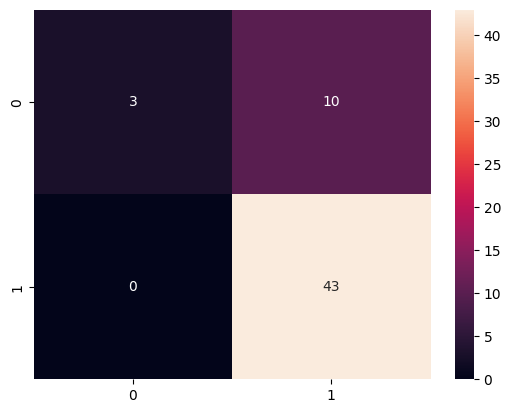

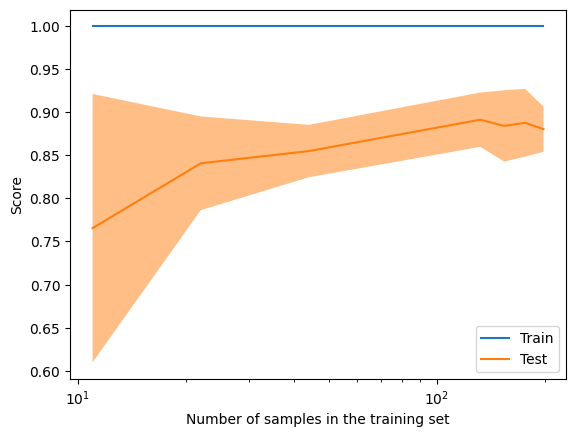

In [86]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_true = y_test
plt.show()
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
print(classification_report(y_true, y_pred))
LearningCurveDisplay.from_estimator(RandomForestClassifier(random_state=42), X, y, train_sizes=[0.05, 0.1, 0.2, 0.6,0.7,0.8,0.9])

#### AdaBoostClassifier

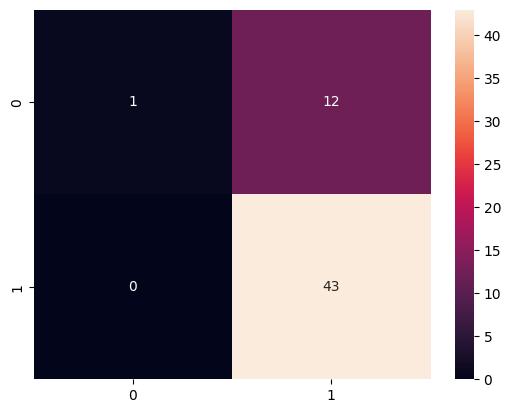

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.78      1.00      0.88        43

    accuracy                           0.79        56
   macro avg       0.89      0.54      0.51        56
weighted avg       0.83      0.79      0.71        56



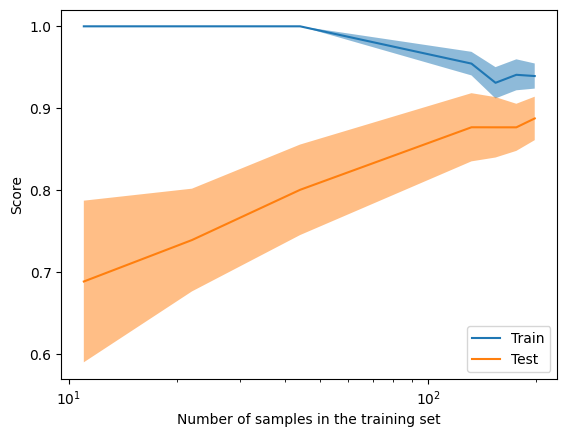

In [87]:
adc = AdaBoostClassifier(random_state=42, algorithm="SAMME")
adc.fit(X_train, y_train)
y_pred = adc.predict(X_test)
y_true = y_test
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
plt.show()
print(classification_report(y_true, y_pred))
LearningCurveDisplay.from_estimator(AdaBoostClassifier(random_state=42, algorithm="SAMME"), X, y, train_sizes=[0.05, 0.1, 0.2, 0.6,0.7,0.8,0.9])

#### ExtraTreesClassifier

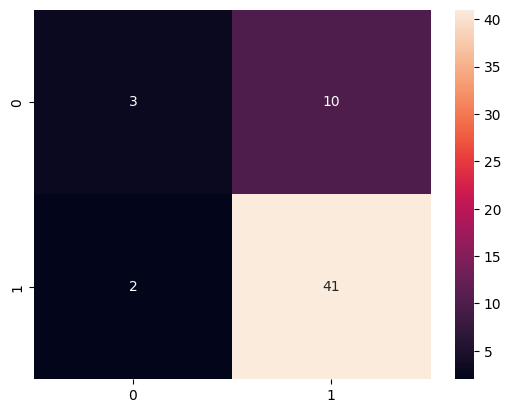

              precision    recall  f1-score   support

           0       0.60      0.23      0.33        13
           1       0.80      0.95      0.87        43

    accuracy                           0.79        56
   macro avg       0.70      0.59      0.60        56
weighted avg       0.76      0.79      0.75        56



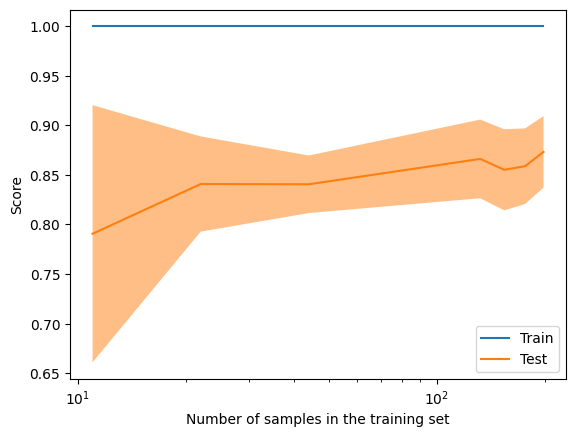

In [88]:
etc = ExtraTreesClassifier(random_state=42)
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)
y_true = y_test
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
plt.show()
print(classification_report(y_true, y_pred))
LearningCurveDisplay.from_estimator(ExtraTreesClassifier(random_state=42), X, y, train_sizes=[0.05, 0.1, 0.2, 0.6,0.7,0.8,0.9])

#### HistGradientBoostingClassifier

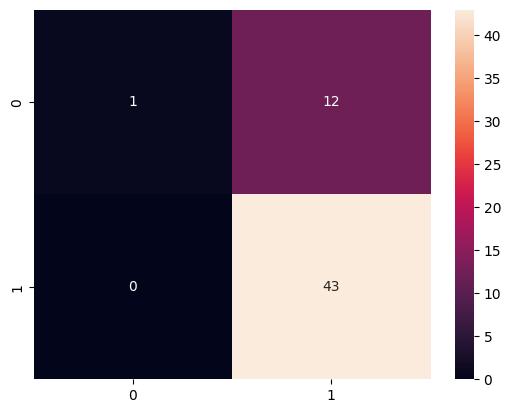

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.78      1.00      0.88        43

    accuracy                           0.79        56
   macro avg       0.89      0.54      0.51        56
weighted avg       0.83      0.79      0.71        56



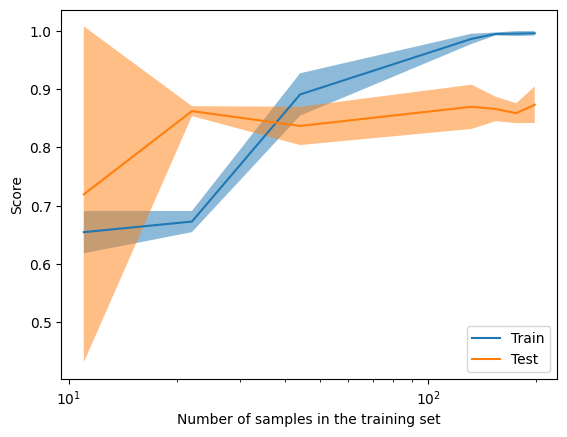

In [89]:
hgbc = HistGradientBoostingClassifier(random_state=42)
hgbc.fit(X_train, y_train)
y_pred = hgbc.predict(X_test)
y_true = y_test
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
plt.show()
print(classification_report(y_true, y_pred))
LearningCurveDisplay.from_estimator(HistGradientBoostingClassifier(random_state=42), X, y, train_sizes=[0.05, 0.1, 0.2, 0.6,0.7,0.8,0.9])

#### GradientBoostingClassifier

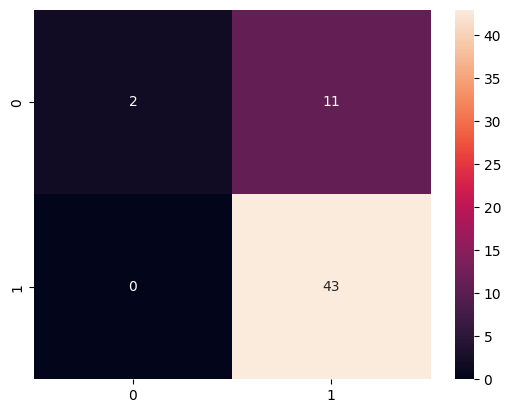

              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           1       0.80      1.00      0.89        43

    accuracy                           0.80        56
   macro avg       0.90      0.58      0.58        56
weighted avg       0.84      0.80      0.74        56



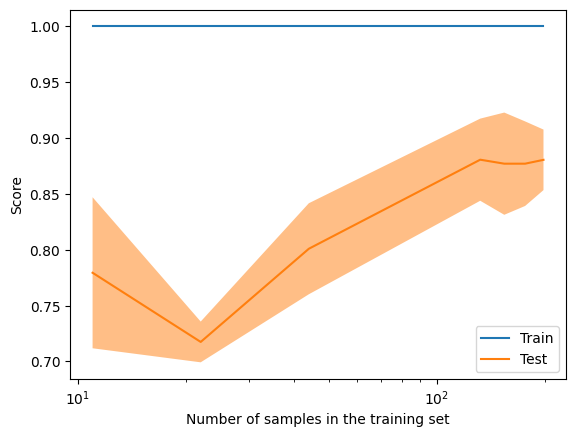

In [90]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
y_true = y_test
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
plt.show()
print(classification_report(y_true, y_pred))
LearningCurveDisplay.from_estimator(GradientBoostingClassifier(random_state=42), X, y, train_sizes=[0.05, 0.1, 0.2, 0.6,0.7,0.8,0.9])

#### PassiveAggressiveClassifier

In [91]:
from sklearn.linear_model import PassiveAggressiveClassifier

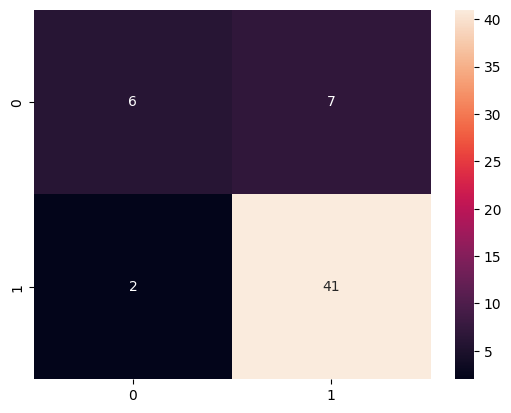

              precision    recall  f1-score   support

           0       0.75      0.46      0.57        13
           1       0.85      0.95      0.90        43

    accuracy                           0.84        56
   macro avg       0.80      0.71      0.74        56
weighted avg       0.83      0.84      0.82        56



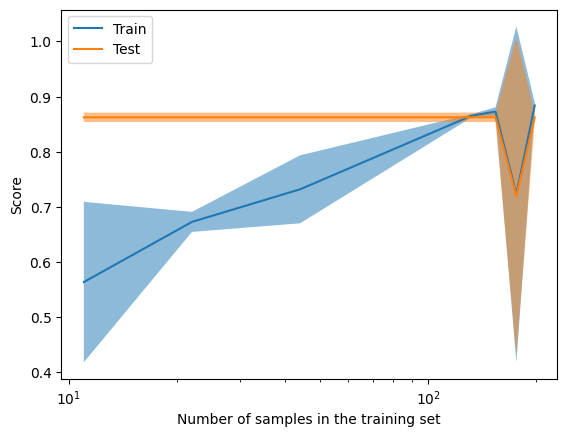

In [92]:
pac = PassiveAggressiveClassifier(random_state=42)
pac.fit(X_train, y_train)
y_pred = pac.predict(X_test)
y_true = y_test
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
plt.show()
print(classification_report(y_true, y_pred))
LearningCurveDisplay.from_estimator(PassiveAggressiveClassifier(random_state=42), X, y, train_sizes=[0.05, 0.1, 0.2, 0.6,0.7,0.8,0.9])

### Классификация для предсказания кластеров

In [93]:
Xc = df_canser2.drop(["LUNG_CANCER", "clust"], axis=1)
yc = df_canser2["clust"]

In [94]:
Xc.rename(columns=d_col, inplace=True)

In [95]:
Xc

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol,coughing,shortness_of_breath,swallowing_difficulty,chest_pain
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0,59,1,2,2,2,1,1,2,2,1,2,1,2,1
272,0,59,2,1,1,1,2,2,2,1,1,1,2,1,1
273,1,55,2,1,1,1,1,2,2,1,1,1,2,1,2
274,1,46,1,2,2,1,1,1,1,1,1,1,1,2,2


In [96]:
yc

0      1
1      2
2      2
3      3
4      2
      ..
271    3
272    2
273    2
274    3
275    1
Name: clust, Length: 276, dtype: int32

In [97]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=5)

In [98]:
scaler_cl = StandardScaler()
Xc_train = scaler_cl.fit_transform(Xc_train)
Xc_test = scaler_cl.transform(Xc_test)

In [99]:
rfc_c = RandomForestClassifier(random_state=42)
rfc_c.fit(Xc_train, yc_train)
yc_pred = rfc_c.predict(Xc_test)

<Axes: >

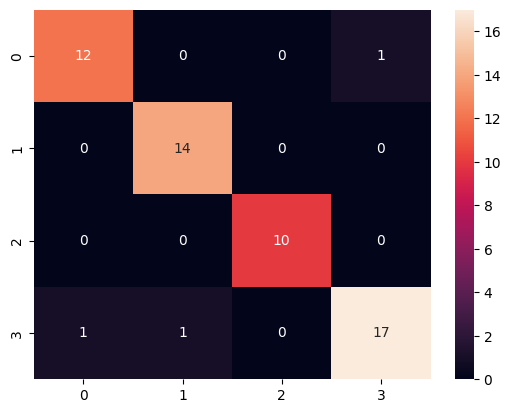

In [100]:
yc_true = yc_test
sns.heatmap(confusion_matrix(yc_true, yc_pred),annot=True)

In [101]:
print(classification_report(yc_true, yc_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        10
           3       0.94      0.89      0.92        19

    accuracy                           0.95        56
   macro avg       0.95      0.95      0.95        56
weighted avg       0.95      0.95      0.95        56



### Вывод

Так как данные очень хорошо структурированы и имеют высокую корреляцию, модели предсказывают очень хорошо.

Так как нас в основном интересует recall (лучше предсказать здоровому человеку рак, чем больному), лучше всего предсказал RandomForest. Поэтому будем использовать только его

### Функция для полного круга предсказания данных вне блокнота

In [102]:
def pred(df, cl_cl, lev_cl, gender_en, level_en, scaler_cl, scaler):
    dd = df.copy()
    dd["GENDER"] = gender_en.transform(dd["GENDER"])
    print(dd["GENDER"].unique())
    Xc = scaler_cl.transform(dd.drop(["Patient Id"], axis=1))
    dd["clust"] = cl_cl.predict(Xc)
    X = scaler.transform(dd.drop(["Patient Id"], axis=1))
    dd["LUNG_CANCER"] = lev_cl.predict(X)
    dd.drop(["clust"], axis=1, inplace=True)
    dd["GENDER"] = gender_en.inverse_transform(dd["GENDER"])
    dd["LUNG_CANCER"] = level_en.inverse_transform(dd["LUNG_CANCER"])
    return dd


## Экспорт

In [103]:
import pickle

Экспорт кодировщиков

In [104]:
with open('label_encoder_gender.pickle', 'wb') as ecn_file:
    pickle.dump(gender_le, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)
with open('label_encoder_cancer.pickle', 'wb') as ecn_file:
    pickle.dump(cancer_le, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

Экспорт моделей

In [105]:
with open('model_rfc.pkl','wb') as f:
    pickle.dump(rfc,f)

with open('model_rfc_clust.pkl','wb') as f:
    pickle.dump(rfc_c,f)

Scaler экспорт

In [106]:
with open('scaler_clust.pkl','wb') as f:
    pickle.dump(scaler_cl,f)
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)